In [1]:
# Load in libraries

import warnings
warnings.filterwarnings('ignore')

#libraries for handling data
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

#label encoders
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()


#libraries for data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
#sns.set_palette('Set2')
sns.set_color_codes("pastel")

#libaries for modelling
# Regression Modelling Algorithms
import statsmodels.api as sm
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor

In [2]:
filepath = "/Users/reejungkim/Documents/Git/Production analysis/Online Retail.xlsx"
pd.ExcelFile(filepath).sheet_names

['Online Retail']

In [3]:
df = pd.read_excel(filepath, sheet_name = 'Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.CustomerID = df.CustomerID.astype(str)

In [6]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [41]:
df['TotalPurchase'] = df.Quantity * df.UnitPrice
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


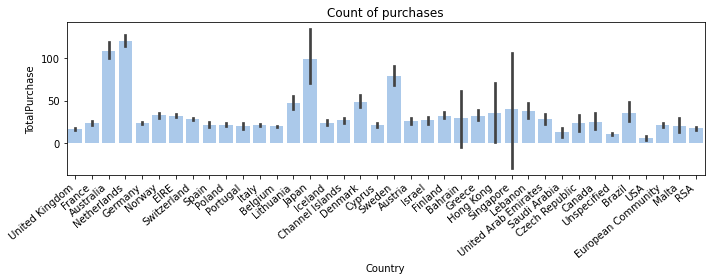

In [63]:
plt.figure(figsize=(10,4))

ax = sns.barplot(x='Country', y='TotalPurchase', color='b', data=df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Count of purchases')
plt.tight_layout()
plt.show()

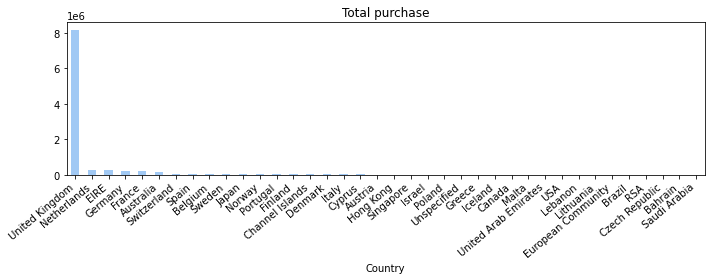

In [64]:
plt.figure(figsize=(10,4))

#ax = sns.barplot(x='Country', y='TotalPurchase', color='b', data=df, estimator=sum)
ax = df.groupby('Country')['TotalPurchase'].sum().sort_values( ascending=False).plot(kind='bar', color='b')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Total purchase')
plt.tight_layout()
plt.show()

In [8]:
df.groupby('Country')['TotalPurchase'].sum().sort_values(ascending=False)[:5]

Country
United Kingdom    8.187806e+06
Netherlands       2.846615e+05
EIRE              2.632768e+05
Germany           2.216982e+05
France            1.974039e+05
Name: TotalPurchase, dtype: float64

In [9]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [10]:
uk_data = df.loc[df.Country=='United Kingdom']

In [11]:
uk_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [12]:
uk_data_group=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPurchase': lambda price: price.sum()})

uk_data_group

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,2,0,0.00
12747.0,366,103,1275,4196.01
12748.0,372,4642,24210,29072.10
12749.0,209,231,1422,3868.20
12820.0,323,59,722,942.34
...,...,...,...,...
18281.0,0,7,54,80.82
18282.0,118,13,98,176.60
18283.0,333,756,1397,2094.88


In [13]:
uk_data_group.columns=['num_days','num_transactions','num_units','spent_money']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,2,0,0.00
12747.0,366,103,1275,4196.01
12748.0,372,4642,24210,29072.10
12749.0,209,231,1422,3868.20
12820.0,323,59,722,942.34


#CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.
#Customer Value = Average Order Value * Purchase Frequency

In [14]:
uk_data_group['avg_order_value']=uk_data_group['spent_money']/uk_data_group['num_transactions']

In [15]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,2,0,0.00,0.000000
12747.0,366,103,1275,4196.01,40.737961
12748.0,372,4642,24210,29072.10,6.262839
12749.0,209,231,1422,3868.20,16.745455
12820.0,323,59,722,942.34,15.971864


In [16]:
uk_data_group.shape

(3951, 5)

In [17]:
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]
purchase_frequency

125.40572007086813

In [18]:
repeat_rate= (
        uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]
)

In [19]:
#Churn Rate
churn_rate=1-repeat_rate

In [20]:
purchase_frequency,repeat_rate,churn_rate

(125.40572007086813, 0.9807643634522906, 0.019235636547709434)

In [21]:
# Approximated Profit Margin
#assume the business has approx 5% profit on the total sale.

uk_data_group['profit_margin']=uk_data_group['spent_money']*0.05

In [22]:
# Customer Value
uk_data_group['CLV']=(uk_data_group['avg_order_value']*purchase_frequency)/churn_rate


In [23]:
#Customer Lifetime Value
uk_data_group['cust_lifetime_value']=uk_data_group['CLV']*uk_data_group['profit_margin']


In [24]:
uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))

In [25]:
uk_data.sort_values(by='InvoiceDate', ascending=True, inplace=True)

In [26]:
sale = uk_data.pivot_table(index=['CustomerID'],columns=['month_yr'],
                           values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()

In [27]:
sale.head()

month_yr,CustomerID,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
0,12346.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,706.27,303.04,0.00,310.78,0.00,771.31,376.30,0.00,301.70,0.00,675.38,312.73,438.50
2,12748.0,4177.68,418.77,389.64,1011.94,1100.37,2224.42,2006.26,1113.27,659.42,4218.65,1385.84,9295.57,1070.27
3,12749.0,0.00,0.00,0.00,0.00,0.00,782.10,0.00,0.00,1750.45,0.00,0.00,572.59,763.06
4,12820.0,0.00,170.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,217.77,343.76,0.00,210.35


In [28]:
#summation of customer value of each row across all columns except first two columns(month_yr and CustomerID)
sale['CLV']=sale.iloc[:,2:].sum(axis=1)

In [29]:
sale.head()

month_yr,CustomerID,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,706.27,303.04,0.00,310.78,0.00,771.31,376.30,0.00,301.70,0.00,675.38,312.73,438.50,3489.74
2,12748.0,4177.68,418.77,389.64,1011.94,1100.37,2224.42,2006.26,1113.27,659.42,4218.65,1385.84,9295.57,1070.27,24894.42
3,12749.0,0.00,0.00,0.00,0.00,0.00,782.10,0.00,0.00,1750.45,0.00,0.00,572.59,763.06,3868.20
4,12820.0,0.00,170.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,217.77,343.76,0.00,210.35,942.34


In [30]:
sale.columns.nunique()

15

In [31]:
X = sale.loc[:, (sale.columns != 'CustomerID') & (sale.columns != 'CLV')] 
#sale.iloc[:, 2:sale.columns.nunique()-1]

In [32]:
y=sale['CLV']

In [33]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [34]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [35]:
linreg.intercept_

-7.275957614183426e-12

In [36]:
linreg.coef_

array([2.30206244e-14, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00])

In [38]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 1.0


In [39]:
#calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1.3090144818186864e-11
MSE 8.249405130413347e-22
RMSE: 2.8721777678990114e-11


In [37]:
y_pred

array([ 3.93330000e+02,  2.90820000e+02,  1.74247000e+03, -3.15296379e-12,
       -8.55760000e+02,  3.64720000e+02,  6.33710000e+02,  1.05855700e+04,
        3.84060000e+02,  5.12810000e+02,  1.19062000e+03,  2.30370000e+02,
       -2.18500000e+01,  2.77050000e+02,  3.96870000e+02,  9.32970000e+02,
        4.85190000e+02,  2.35000000e+03,  3.44140000e+02,  2.74448000e+03,
        1.98358000e+03,  3.10050000e+02,  1.61845000e+04,  3.31000000e+02,
        1.75200000e+02,  8.99400000e+01,  1.09878000e+03,  9.11530000e+02,
        3.86074000e+03,  3.02460000e+02,  5.84458000e+03,  1.21170000e+02,
        3.36543000e+03, -7.27595761e-12,  1.61380000e+02,  3.24240000e+02,
        8.06410000e+02,  5.90930000e+02,  4.14040000e+02,  1.24020000e+03,
        5.07290000e+02,  1.99028000e+03,  6.12080000e+02,  1.08371000e+03,
        1.28617000e+03,  7.97070000e+02,  4.28680000e+02,  1.88020000e+02,
        2.49720000e+02,  1.07364800e+04,  1.14140000e+02,  5.07840000e+02,
        5.66580000e+02,  